In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import ariel_load
import ariel_simple
import tqdm
kgs.n_workers = 7

local


In [2]:
%%time
train_data = kgs.load_all_train_data()
test_data = kgs.load_all_test_data()
len(train_data), len(test_data)
train_data = train_data

CPU times: user 496 ms, sys: 103 ms, total: 599 ms
Wall time: 1.84 s


In [3]:
def robust_linear_fit_rms(X, Y, drop_frac=0.05, do_print=False):
    X = np.asarray(X)
    Y = np.asarray(Y)

    # Fit Y = aX + b using least squares
    A = np.vstack([X, np.ones_like(X)]).T
    a, b = np.linalg.lstsq(A, Y, rcond=None)[0]

    # Predicted Y and residuals
    Y_pred = a * X + b
    residuals = Y - Y_pred
    abs_resid = np.abs(residuals)

    # Remove worst 5% (highest absolute residuals)
    if drop_frac>0:
        n = len(residuals)
        keep = int(n * (1 - drop_frac))
        indices = np.argpartition(abs_resid, keep)[:keep]
    #print(keep, len(residuals))
    else:
        indices = np.arange(len(residuals))

    # Compute RMS of the remaining residuals
    rms = np.sqrt(np.mean(residuals[indices] ** 2))
    if do_print:
        print(a,b)
    return rms,residuals

In [ ]:
df = 0.05
kgs.sanity_checks_without_errors = True
for jj in [4]:
    model = ariel_simple.SimpleModel()
    model.run_in_parallel = False #(jj==0)
    match jj:
        case 0:
            name = 'Baseline'
        case 1:
            name = 'No background removal'
            for ii in range(2):
                model.loaders[ii].apply_full_sensor_corrections.remove_background_based_on_rows = False
                model.loaders[ii].apply_full_sensor_corrections.remove_background_based_on_pixels = False
        case 2:
            name = 'New background removal'
            for ii in range(2):                
                model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca = True 
                model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[3] = 10000
                model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[2] = 10000
                model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[4] = True
                model.loaders[ii].apply_full_sensor_corrections.remove_background_based_on_rows = False
                model.loaders[ii].apply_full_sensor_corrections.remove_background_based_on_pixels = False
        case 3:
            name = 'New background removal 2'
            for ii in range(2):                
                model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca = True                 
                model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[3] = 10000
                model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[2] = 10000
                model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[4] = True
                model.loaders[ii].apply_full_sensor_corrections.remove_background_based_on_rows = False
                model.loaders[ii].apply_full_sensor_corrections.remove_background_based_on_pixels = False
            model.loaders[1].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[1] = 1
        case 4:
            name = 'New background removal 3'
            for ii in range(2):                
                model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca = True                 
                model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[3] = 10000
                model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[2] = 10000
                model.loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[4] = True
                model.loaders[ii].apply_full_sensor_corrections.remove_background_based_on_rows = False
                model.loaders[ii].apply_full_sensor_corrections.remove_background_based_on_pixels = False
            model.loaders[1].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[1] = 1
            model.loaders[0].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[1] = 5
            base_shapes = kgs.dill_load(kgs.temp_dir + '/explore_base_shape.pickle')
            all_a = cp.stack([r[0] for r in base_shapes])
            a = cp.nanmedian(all_a,0)
            S,components,weights = kgs.dill_load(kgs.temp_dir + '/explore_bad_pixels_pca_v3.pickle')
            model.loaders[0].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[0] = [[a[None,:]]+components[0]]
    model.train(train_data)
    data = train_data
    inferred_data = model.infer(data)
    print(name)
    solution = kgs.make_submission_dataframe(data, include_sigma=False)
    submission = kgs.make_submission_dataframe(inferred_data, False)
    print(1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=df)[0], 1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=0)[0])
    print(1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=df)[0],
         1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=0)[0])
    kgs.sanity_checks['simple_residual_diff_FGS'] = kgs.SanityCheckValue('simple_residual_diff_FGS', 12, [-1,1])
    kgs.sanity_checks['simple_residual_diff_FGS'].seen_all = [d.diagnostics['simple_residual_diff_FGS'] for d in inferred_data]
    kgs.sanity_checks['simple_residual_diff_AIRS'] = kgs.SanityCheckValue('simple_residual_diff_AIRS', 12, [-1,1])
    kgs.sanity_checks['simple_residual_diff_AIRS'].seen_all = [d.diagnostics['simple_residual_diff_AIRS'] for d in inferred_data]
    kgs.dill_save(kgs.temp_dir + '/compare_simple'+str(jj)+'.pickle', (data,inferred_data,kgs.sanity_checks,name))

Baseline
0.0004997754877218447 -1.867009044972836e-05
-0.014343516984583627 -2.364584349007984e-05
136.79238951815606 72.42879286152494
No background removal
0.003661447775300319 -2.1657008739320465e-05
0.007337054198827347 -4.363148114250171e-06
134.57869364255166 72.99854617766388
New background removal
0.003429901946446248 -1.8892422268339237e-05
0.0070330270318536715 -3.816488583112274e-06
135.58088832038996 72.71515593901108
New background removal 2
0.003420723742886815 -1.8629401683270322e-05
0.007914919385499541 -1.569177458844396e-05
134.77633565699676 70.38504947143988


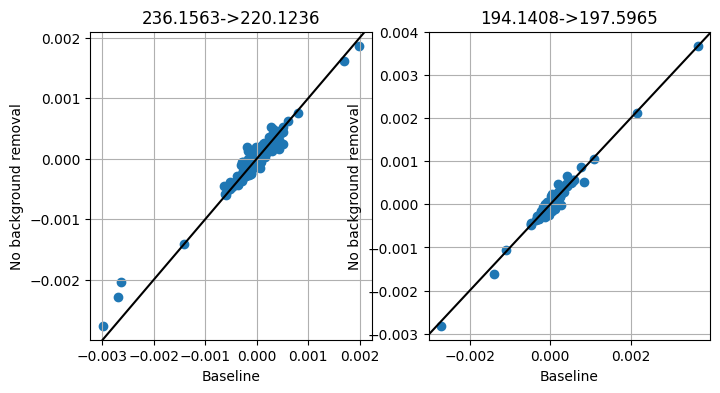

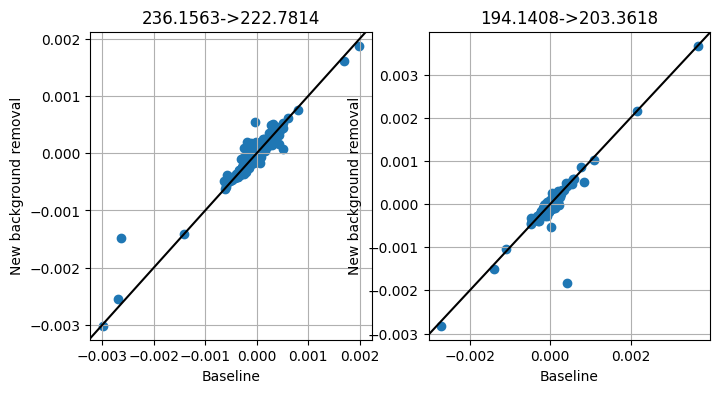

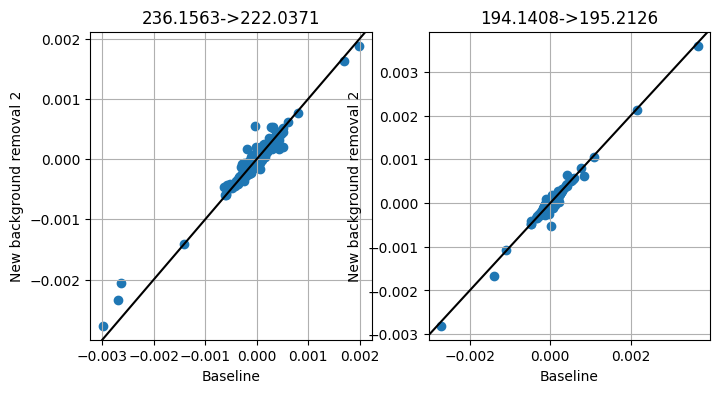

In [4]:
def process_solution(dat):
    print(dat[3])
    solution = kgs.make_submission_dataframe(dat[0], include_sigma=False)
    submission = kgs.make_submission_dataframe(dat[1], False)
    dr1, fgs_err = robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), do_print=True)
    dr2, airs_err = robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1), do_print=True)
    print(1e6*dr1,1e6*dr2)
    return fgs_err,airs_err,dat[3]
dat_base = process_solution(kgs.dill_load(kgs.temp_dir + '/compare_simple'+str(0)+'.pickle'))
for jj in [1,2,3]:
    dat_this = process_solution(kgs.dill_load(kgs.temp_dir + '/compare_simple'+str(jj)+'.pickle'))
    _,ax = plt.subplots(1,2,figsize=(8,4))
    for ii in range(2):
        plt.sca(ax[ii])
        plt.grid(True)
        plt.scatter(dat_base[ii], dat_this[ii])
        plt.axline((0,0), slope=1, color='black')
        plt.title(f'{1e6*kgs.rms(dat_base[ii]):.4f}->{1e6*kgs.rms(dat_this[ii]):.4f}')
        plt.xlabel(dat_base[2])
        plt.ylabel(dat_this[2])

In [ ]:
#ind=np.argmax(dat_this[0])
#ind,dat_this[0][ind]
ind=773 # worst with new invalidation
ind=34 # worst with new mean
#ind=np.argmax(dat_this[0]-dat_base[0])
#ind,dat_this[0][ind]
ind = 6

In [ ]:
import copy
importlib.reload(ariel_load)
dd=copy.deepcopy(train_data[ind])
dd.transits = dd.transits[0:1]
loaders=ariel_load.default_loaders()
dd.load_to_step(0,loaders)
loaders[0].cache_steps = []
#for ii in range(2):
#    loaders[ii].apply_full_sensor_corrections.inpainting_2d = False
#    loaders[ii].apply_full_sensor_corrections.inpainting_wavelength = False
#dd.load_to_step(3,loaders)
#plt.figure()
#plt.imshow(cp.mean(dd.transits[0].data[0].data,0).reshape(32,32).get())\
for ii in range(2):
    #loaders[ii].apply_pixel_corrections.mask_dead = False
    #loaders[ii].apply_pixel_corrections.mask_hot = False
    #loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca = True  

    loaders[ii].apply_pixel_corrections.mask_dead = True
    loaders[ii].apply_pixel_corrections.mask_hot = True
    # loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca = True 
    # loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[3] = 10000
    # loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[2] = 10000
    # loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[4] = True
    loaders[ii].apply_full_sensor_corrections.remove_background_based_on_rows = False
    loaders[ii].apply_full_sensor_corrections.remove_background_based_on_pixels = False
dd.load_to_step(2,loaders)
#dd.transits[0].data[1].data += 1000
dd.load_to_step(5,loaders)
#plt.figure()
#x1 = dd.transits[0].data[0].data.get()
#plt.plot(x1)
m0 = cp.mean(dd.transits[0].data[0].data).get()
x1=cp.mean(dd.transits[0].data[1].data,0).get()
#plt.plot()
dd.load_to_step(0,loaders)
loaders=ariel_load.default_loaders()
loaders[0].cache_steps = []
for ii in range(2):
    #loaders[ii].apply_pixel_corrections.mask_dead = False
    #loaders[ii].apply_pixel_corrections.mask_hot = False
    #loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca = True  

    loaders[ii].apply_pixel_corrections.mask_dead = True
    loaders[ii].apply_pixel_corrections.mask_hot = True
    loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca = True 
    #loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[1] = 1
    loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[3] = 10000
    loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[2] = 10000
    loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[4] = True
    loaders[ii].apply_full_sensor_corrections.remove_background_based_on_rows = False
    loaders[ii].apply_full_sensor_corrections.remove_background_based_on_pixels = False
dd.load_to_step(2,loaders)
#dd.transits[0].data[1].data += 1000
#print('!!! 3x')
dd.load_to_step(5,loaders)
#plt.figure()
#plt.plot(dd.transits[0].data[0].data.get())
#plt.figure()
#plt.imshow(cp.mean(dd.transits[0].data[0].data,0).reshape(32,32).get())
# plt.figure()
# ratio=dd.transits[0].data[0].data.get()/x1
# plt.plot(ratio)
# dd.load_to_step(0,loaders)
# np.max(ratio)/np.min(ratio)
print(cp.mean(dd.transits[0].data[0].data).get()-m0)
x2 = cp.mean(dd.transits[0].data[1].data,0).get()
dd.load_to_step(0,loaders)
loaders=ariel_load.default_loaders()
loaders[0].cache_steps = []
for ii in range(2):
    #loaders[ii].apply_pixel_corrections.mask_dead = False
    #loaders[ii].apply_pixel_corrections.mask_hot = False
    #loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca = True  

    loaders[ii].apply_pixel_corrections.mask_dead = True
    loaders[ii].apply_pixel_corrections.mask_hot = True
    # loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca = True 
    # loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[3] = 10000
    # loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[2] = 10000
    # loaders[ii].apply_full_sensor_corrections.remove_bad_pixels_pca_inputs[4] = True
    # loaders[ii].apply_full_sensor_corrections.remove_background_based_on_rows = False
    # loaders[ii].apply_full_sensor_corrections.remove_background_based_on_pixels = False
    #loaders[ii].apply_full_sensor_corrections.remove_background_based_on_rows = False
    #loaders[ii].apply_full_sensor_corrections.remove_background_based_on_pixels = False
dd.load_to_step(2,loaders)
#dd.transits[0].data[1].data += 1000
dd.load_to_step(5,loaders)
#plt.figure()
#plt.plot(dd.transits[0].data[0].data.get())
#plt.figure()
#plt.imshow(cp.mean(dd.transits[0].data[0].data,0).reshape(32,32).get())
# plt.figure()
# ratio=dd.transits[0].data[0].data.get()/x1
# plt.plot(ratio)
# dd.load_to_step(0,loaders)
# np.max(ratio)/np.min(ratio)
print(cp.mean(dd.transits[0].data[0].data).get()-m0)
x3 = cp.mean(dd.transits[0].data[1].data,0).get()
plt.figure();plt.plot(x2-x1);#plt.plot(x3-x1);
#plt.figure();plt.plot(x3-x1);

In [ ]:
%debug

In [ ]:
import copy
importlib.reload(ariel_load)
dd=copy.deepcopy(train_data[ind])
print(dat_this[0][ind]-0*dd.diagnostics['training_spectrum'][0])
print(dat_base[0][ind]-0*dd.diagnostics['training_spectrum'][0])
print(dat_this[0][ind]-dat_base[0][ind])
dd.transits = dd.transits[0:1]
loaders=ariel_load.default_loaders()
loaders[0].cache_steps = []
dd.load_to_step(5,loaders)
#adjust_vals = np.linspace(-5,5,11)
#xx=1.3020820197679759+0.0567279459538884
adjust_vals = np.linspace(-2000,2000,10)
res = []
for mean_adjust in adjust_vals:
    ddd = copy.deepcopy(dd)
    ddd.transits[0].data[1].data += mean_adjust
    #print(cp.mean(ddd.transits[0].data[0].data))
    model = ariel_simple.SimpleModel()
    model.train([ddd])
    ddd = model.infer([ddd])[0]
    #print(cp.mean(ddd.transits[0].data[0].data))
    res.append(ddd.spectrum[0]-ddd.diagnostics['training_spectrum'][0])
plt.plot(adjust_vals,res-np.mean(res))

In [ ]:
dat_this[0][ind]